In [1]:
import wandb
import glob
import tbparse
import matplotlib.pyplot as plt
import scipy
import json
import numpy as np

2025-04-07 05:08:14.686029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743998894.701530 2421284 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743998894.706676 2421284 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743998894.718920 2421284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743998894.718937 2421284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743998894.718939 2421284 computation_placer.cc:177] computation placer alr

In [2]:
api = wandb.Api()
runs = api.runs(
    path="mistry-lab/dissertation"
)
len(runs)

130

In [3]:
import json
json.loads(runs.objects[0].json_config)

{'_wandb': {'value': {'m': [],
   't': {'1': [12, 45, 50, 55],
    '2': [12, 45, 50, 55],
    '3': [2, 13, 14, 16, 23, 35, 55],
    '4': '3.10.16',
    '5': '0.19.6',
    '8': [5],
    '12': '0.19.6',
    '13': 'linux-x86_64'},
   'code_path': 'code/scripts/evaluate.py',
   'cli_version': '0.19.6',
   'python_version': '3.10.16'},
  'desc': None},
 'alg': {'value': {'name': 'ppo',
   'params': {'num_envs': 2048,
    'num_evals': 14,
    'batch_size': 1024,
    'discounting': 0.97,
    'entropy_cost': 0.01,
    'action_repeat': 1,
    'learning_rate': 0.0003,
    'num_eval_envs': 1024,
    'num_timesteps': 2000000,
    'unroll_length': 5,
    'episode_length': 1000,
    'reward_scaling': 10,
    'num_minibatches': 32,
    'deterministic_eval': True,
    'num_updates_per_batch': 4,
    'normalize_observations': True},
   'module_path': 'brax.training.agents.ppo.train',
   'include_time': False,
   'checkpoint_path': 'brax.training.agents.ppo.checkpoint',
   'checkpoint_keyword_arg': 'sav

In [4]:
ppo_runs = api.runs(
    path="mistry-lab/dissertation",
    filters={"config.alg.value.name": "ppo"}
)
len(ppo_runs)

10

In [5]:
shac_runs = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.env.value.kwargs.reward_shaping": False},
            {"config.general.experiment_name": {
                "$exists": False
            }},
        ]
    }
)
len(shac_runs)

10

In [6]:
shac_reward_shaping_runs = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.env.value.kwargs.reward_shaping": True},
            {"config.general.experiment_name": "with_shaping"},
        ]
    }
)
len(shac_reward_shaping_runs)

10

In [7]:
shac_runs_no_shaping = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.env.value.kwargs.reward_shaping": False},
            {"config.general.experiment_name": "no_shaping"},
        ]
    }
)
len(shac_runs_no_shaping)

10

In [4]:
def get_mean_values(wandb_runs, name, threshold = 0, rolling_num = 0):
    rewards = []

    for run in wandb_runs:
        file = glob.glob(f"wandb/*{run.id}")[0]
        df = tbparse.SummaryReader(file).scalars
        reward = df[df["tag"] == name]
        rewards.append(reward)

    steps = rewards[0]["step"].values

    num = 0
    means = []
    rolling_values = []
    num_evals = len(rewards)
    threshold_exceeded = False
    for step in range(len(rewards[0])):
        rows = [rewards[idx].iloc[step] for idx in range(len(rewards))]
        rolling_values += [row["value"] for row in rows]

        if num < rolling_num:
            num += 1
            continue
        values = np.asarray([rolling_values])
        mean = np.mean(values)

        if not threshold_exceeded and mean > threshold:
            threshold_exceeded = True
            print(f"Threshold exceeded at step {steps[step]}")

        means.append(mean)
        rolling_values = rolling_values[num_evals:]

    return means, steps[rolling_num:]

In [17]:
def get_mean_value_with_confidence(wandb_runs, name, threshold = 0, rolling_num = 0, max_step = None):
    rewards = []

    for run in wandb_runs:
        file = glob.glob(f"wandb/*{run.id}")[0]
        df = tbparse.SummaryReader(file).scalars
        reward = df[df["tag"] == name]
        rewards.append(reward)

    means = []
    lower_intervals = []
    upper_intervals = []

    steps = rewards[0]["step"].values

    num = 0
    rolling_values = []
    num_evals = len(rewards)
    threshold_exceeded = False

    if max_step is None:
        max_step = len(rewards[0])

    for step in range(max_step):
        rows = [rewards[idx].iloc[step] for idx in range(len(rewards))]
        rolling_values += [row["value"] for row in rows]

        if num < rolling_num:
            num += 1
            continue
        values = np.asarray([rolling_values])
        mean = np.mean(values)

        if not threshold_exceeded and mean > threshold:
            threshold_exceeded = True
            print(f"Threshold exceeded at step {steps[step]}")

        means.append(mean)
        bs = scipy.stats.bootstrap(values, np.mean)

        rolling_values = rolling_values[num_evals:]

        lower_intervals.append(bs.confidence_interval.low)
        upper_intervals.append(bs.confidence_interval.high)

    return means, lower_intervals, upper_intervals, steps[rolling_num:max_step]

In [10]:
ppo_means = get_mean_value_with_confidence(
    ppo_runs,
    "eval/avg_episode_length",
    threshold=800,
)

shac_means = get_mean_value_with_confidence(
    shac_runs,
    "eval/avg_episode_length",
    threshold=800,
    rolling_num=10
)

shac_reward_shaping_means = get_mean_value_with_confidence(
    shac_reward_shaping_runs,
    "eval/avg_episode_length",
    rolling_num=10
)

shac_no_shaping_means = get_mean_value_with_confidence(
    shac_runs_no_shaping,
    "eval/avg_episode_length",
    rolling_num=10
)

Threshold exceeded at step 655360


/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Threshold exceeded at step 921600
Threshold exceeded at step 20480


/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Threshold exceeded at step 20480


In [5]:
def plot_reward(ax, means, lower_intervals, upper_intervals, step_values, **kwargs):
    ax.plot(step_values, means, **kwargs)
    ax.fill_between(step_values, (lower_intervals), (upper_intervals), color='b', alpha=.1)

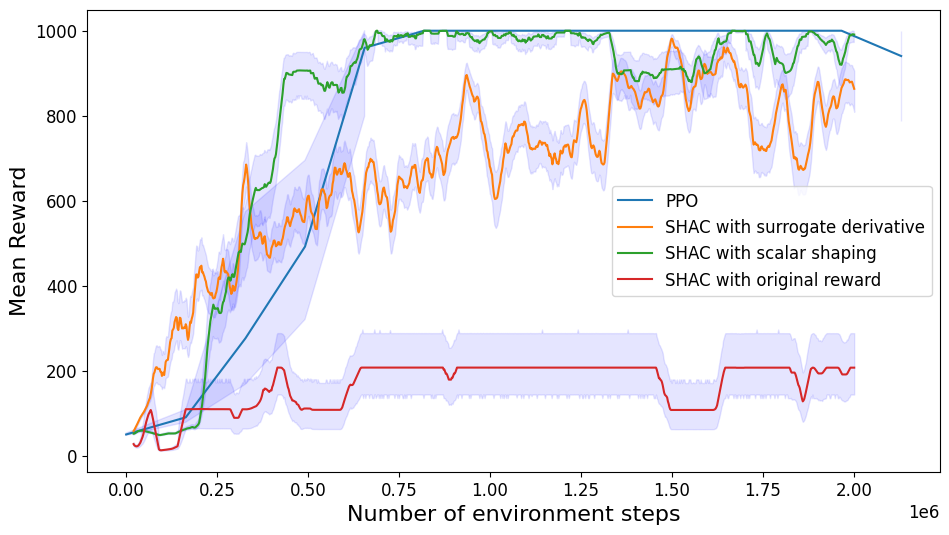

In [ ]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([prefix / 4 * 10**6 for prefix in range(0, 9)])

plot_reward(ax, *ppo_means, label="PPO")
plot_reward(ax, *shac_means, label="SHAC with surrogate derivative")
plot_reward(ax, *shac_reward_shaping_means, label="SHAC with scalar shaping")
plot_reward(ax, *shac_no_shaping_means, label="SHAC with original reward")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")

In [12]:
critic_loss = "training/critic_loss"

shac_losses, step_values = get_mean_values(shac_runs, critic_loss, 10)
shac_reward_shaping_losses, step_values = get_mean_values(shac_reward_shaping_runs, critic_loss, 10)

Threshold exceeded at step 6144
Threshold exceeded at step 292864


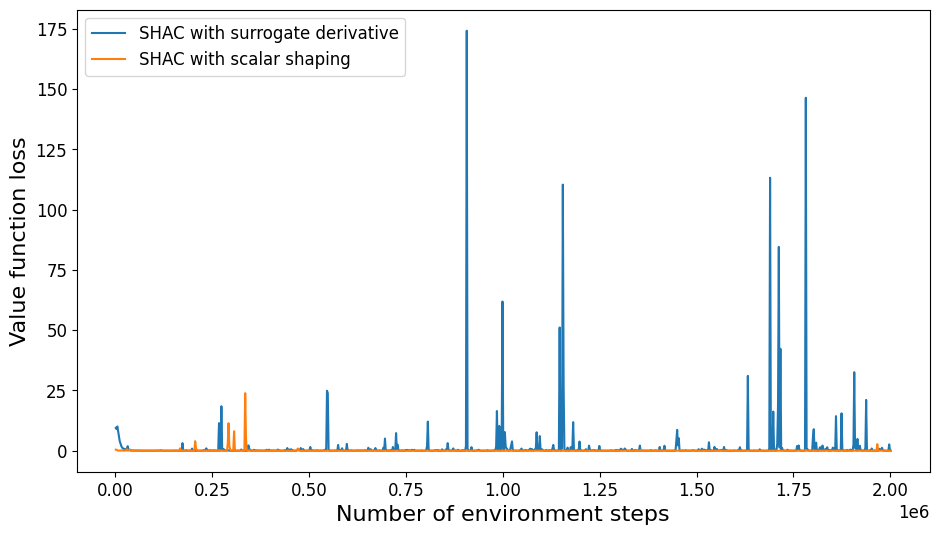

In [13]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([prefix / 4 * 10**6 for prefix in range(0, 9)])

# ax.set_ylim([0, 20])

ax.plot(step_values, shac_losses, label="SHAC with surrogate derivative")
ax.plot(step_values, shac_reward_shaping_losses, label="SHAC with scalar shaping")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Value function loss', fontsize=16)
plt.legend(loc="upper left", fontsize=12)
# plt.show()
plt.savefig("mean_critic_loss")

In [14]:
shac_runs_simple_shaping_derivative = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.env.value.kwargs.reward_shaping": False},
            {"config.general.experiment_name": "simple_shaping"},
        ]
    }
)
len(shac_runs_simple_shaping_derivative)

10

In [15]:
shac_runs_simple_shaping = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.env.value.kwargs.reward_shaping": True},
            {"config.general.experiment_name": "simple_shaping"},
        ]
    }
)
len(shac_runs_simple_shaping)

10

In [16]:
shac_runs_simple_shaping_derivative_means = get_mean_value_with_confidence(
    shac_runs_simple_shaping_derivative,
    "eval/avg_episode_length",
    threshold=800,
    rolling_num=10
)

shac_runs_simple_shaping_means = get_mean_value_with_confidence(
    shac_runs_simple_shaping,
    "eval/avg_episode_length",
    threshold=800,
    rolling_num=10
)

Threshold exceeded at step 219136


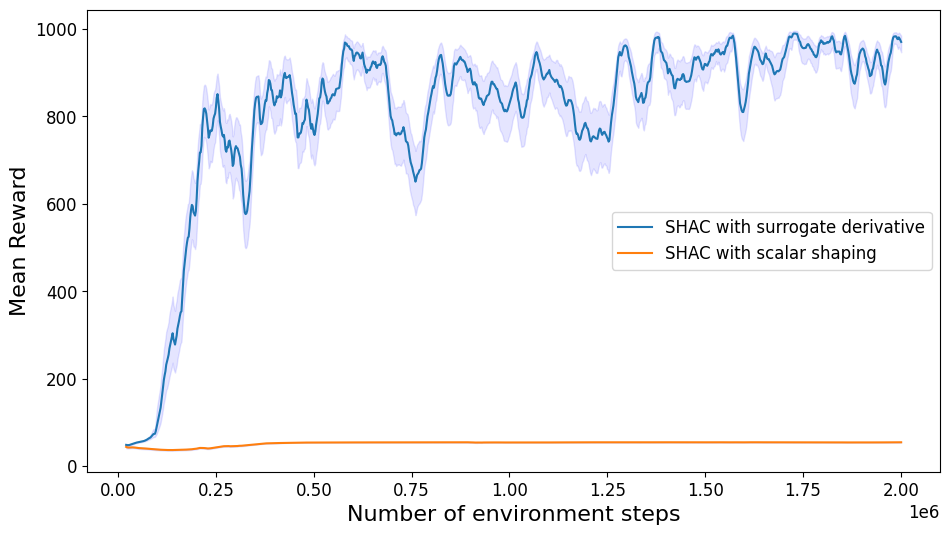

In [33]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([prefix / 4 * 10**6 for prefix in range(0, 9)])

plot_reward(ax, *shac_runs_simple_shaping_derivative_means, label="SHAC with surrogate derivative")
plot_reward(ax, *shac_runs_simple_shaping_means, label="SHAC with scalar shaping")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")

In [22]:
ghac_runs_largest_xi = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.actor_xi": 1.0},
        ]
    }
)
len(ghac_runs_largest_xi)

10

In [23]:
ghac_runs_large_xi = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.actor_xi": 0.95},
        ]
    }
)
len(ghac_runs_large_xi)

10

In [24]:
ghac_runs_small_xi = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.actor_xi": 0.0},
        ]
    }
)
len(ghac_runs_small_xi)

10

In [25]:
ghac_runs_largest_xi_means = get_mean_value_with_confidence(
    ghac_runs_largest_xi,
    "eval/avg_episode_length",
    threshold=800,
    rolling_num=10
)

ghac_runs_large_xi_means = get_mean_value_with_confidence(
    ghac_runs_large_xi,
    "eval/avg_episode_length",
    threshold=800,
    rolling_num=10
)

ghac_runs_small_xi_means = get_mean_value_with_confidence(
    ghac_runs_small_xi,
    "eval/avg_episode_length",
    threshold=800,
    rolling_num=10
)

Threshold exceeded at step 63488


/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Threshold exceeded at step 79872


/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


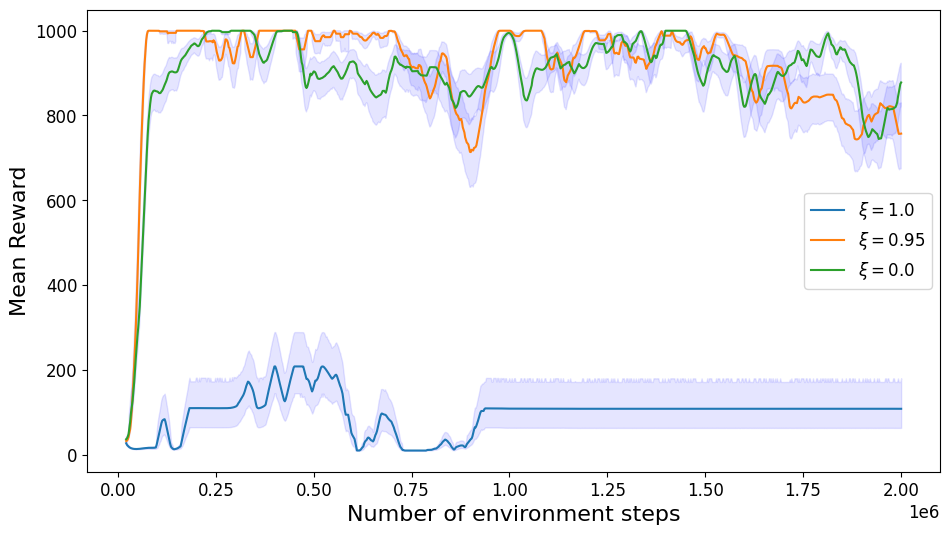

In [28]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([prefix / 4 * 10**6 for prefix in range(0, 9)])

plot_reward(ax, *ghac_runs_largest_xi_means, label=r"$\xi = 1.0$")
plot_reward(ax, *ghac_runs_large_xi_means, label=r"$\xi = 0.95$")
plot_reward(ax, *ghac_runs_small_xi_means, label=r"$\xi = 0.0$")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")

In [9]:
dissertation_path = "alexanderwebb03-university-of-edinburgh/dissertation_sweep"

runs = api.runs(
    path=dissertation_path
)
len(runs)

84

In [10]:
ghac_runs_large_batch = api.runs(
    path=dissertation_path,
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.num_updates_per_batch": 16},
            {"config.general.experiment_name": "large_batch"},
        ]
    }
)

len(ghac_runs_large_batch)

21

In [11]:
ghac_runs_large_batch_with_derivative = api.runs(
    path=dissertation_path,
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.num_updates_per_batch": 16},
            {"config.general.experiment_name": "large_batch_custom_derivative"},
        ]
    }
)

len(ghac_runs_large_batch_with_derivative)

21

In [12]:
run = ghac_runs_large_batch_with_derivative[0]
json.loads(run.json_config)["alg"]["value"]["params"]["actor_xi"]

0

In [31]:
def get_return_at_timestamp(wandb_runs, name):
    xis = []
    terminal_rewards = []
    for run in wandb_runs:
        file = glob.glob(f"wandb/*{run.id}")[0]
        df = tbparse.SummaryReader(file).scalars

        xi = json.loads(run.json_config)["alg"]["value"]["params"]["actor_xi"]
        reward = df[df["tag"] == name]["value"].iloc[-1]

        xis.append(xi)
        terminal_rewards.append(reward)
    
    return xis, terminal_rewards

def get_first_timestamp(wandb_runs, name, target_value):
    xis = []
    terminal_rewards = []
    for run in wandb_runs:
        file = glob.glob(f"wandb/*{run.id}")[0]
        df = tbparse.SummaryReader(file).scalars

        xi = json.loads(run.json_config)["alg"]["value"]["params"]["actor_xi"]
        reward = df[(df["tag"] == name) & (df["value"] == target_value)]["step"]
        print(reward.min())

        xis.append(xi)
        terminal_rewards.append(reward.min())
    
    return xis, terminal_rewards

In [32]:
ghac_runs_large_batch_with_derivative_means = get_first_timestamp(
    ghac_runs_large_batch,
    "eval/avg_episode_length",
    1_000
)

2490368
2359296
nan
2228224
2228224
2228224
2359296
2228224
2359296
2359296
2359296
2097152
2359296
2228224
2097152
2097152
2097152
1966080
1966080
2228224
nan


/tmp/ipykernel_940519/882708754.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


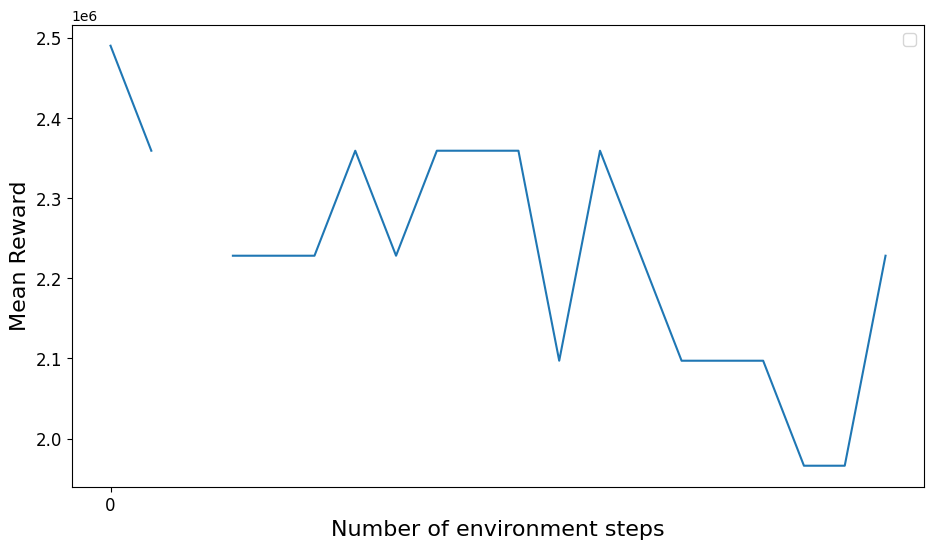

In [33]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([prefix / 4 * 10**6 for prefix in range(0, 9)])

#ax.plot(*ghac_runs_large_batch_means)
ax.plot(*ghac_runs_large_batch_with_derivative_means)

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")

In [14]:
scalar_reward_ghac = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.num_envs": 2048},
            {"config.general.experiment_name": "large_batch_scalar"},
        ]
    }
)
len(scalar_reward_ghac)

10

In [15]:
reward_ghac = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.alg.value.params.num_envs": 2048},
            {"config.general.experiment_name": "large_batch"},
        ]
    }
)
len(reward_ghac)

2

In [21]:
reward_shac = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.alg.value.params.num_envs": 2048},
            {"config.general.experiment_name": "large_batch"},
        ]
    }
)
len(reward_shac)

10

In [22]:
scalar_reward_shac = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "diffrl_shac"},
            {"config.alg.value.params.num_envs": 2048},
            {"config.general.experiment_name": "large_batch_scalar"},
        ]
    }
)
len(scalar_reward_shac)

10

In [23]:
scalar_reward_ghac_means = get_mean_value_with_confidence(
    scalar_reward_ghac,
    "eval/avg_episode_length",
    threshold=800,
)

# reward_ghac_means = get_mean_value_with_confidence(
#     reward_ghac,
#     "eval/avg_episode_length",
#     threshold=800,
# )

scalar_reward_shac_means = get_mean_value_with_confidence(
    scalar_reward_shac,
    "eval/avg_episode_length",
    threshold=800,
)

reward_shac_means = get_mean_value_with_confidence(
    reward_shac,
    "eval/avg_episode_length",
    threshold=800,
)

Threshold exceeded at step 1441792


/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/alexaldermanwebb/.local/share/virtualenvs/brax-txpWQzqs/lib/python3.10/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


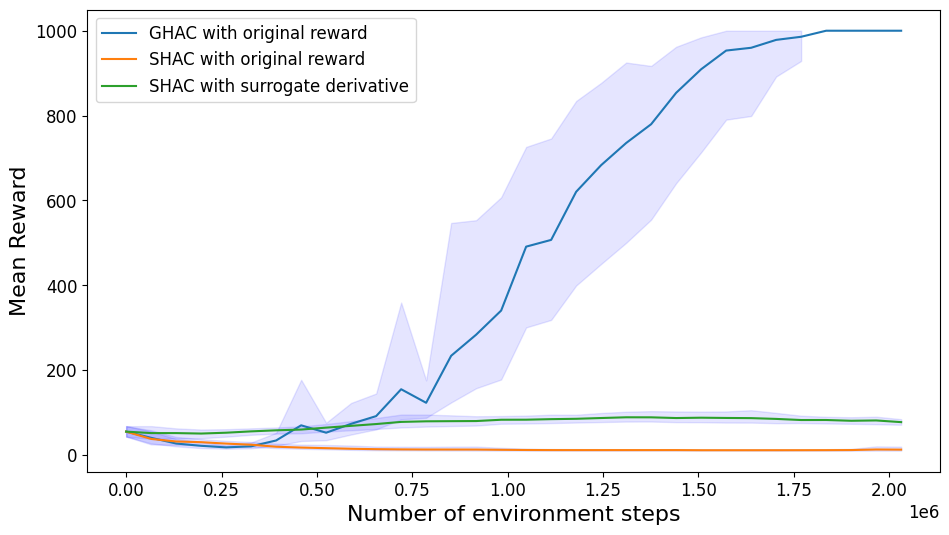

In [24]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([prefix / 4 * 10**6 for prefix in range(0, 9)])

plot_reward(ax, *scalar_reward_ghac_means, label=r"GHAC with original reward")
plot_reward(ax, *scalar_reward_shac_means, label=r"SHAC with original reward")
plot_reward(ax, *reward_shac_means, label=r"SHAC with surrogate derivative")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")

In [6]:
reward_generalized_hac_finger = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "generalized_hac"},
            {"config.general.experiment_name": "flip"},
        ]
    }
)
len(reward_generalized_hac_finger)

5

In [9]:
reward_ppo_finger = api.runs(
    path="mistry-lab/dissertation",
    filters={
        "$and": [
            {"config.alg.value.name": "ppo"},
            {"config.general.experiment_name": "flip"},
        ]
    }
)
len(reward_ppo_finger)

5

In [24]:
reward_generalized_hac_finger_means = get_mean_value_with_confidence(
    reward_generalized_hac_finger,
    "eval/episode_reward",
    threshold=800,
)

reward_ppo_finger_means = get_mean_value_with_confidence(
    reward_ppo_finger,
    "eval/episode_reward",
    threshold=800,
    max_step=43
)

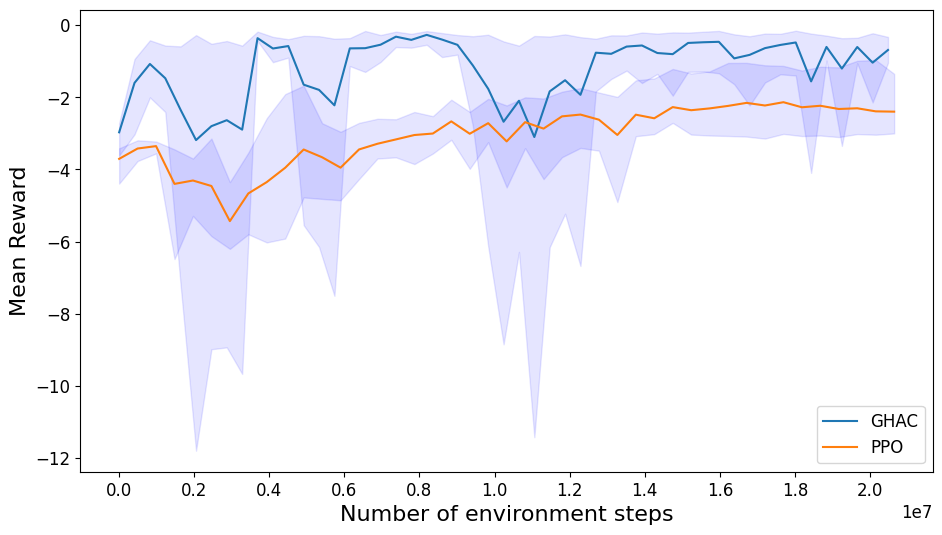

In [28]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([2 * prefix * 10**6 for prefix in range(0, 11)])

plot_reward(ax, *reward_generalized_hac_finger_means, label=r"GHAC")
plot_reward(ax, *reward_ppo_finger_means, label=r"PPO")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")

In [31]:
critic_loss = "training/critic_loss"

ghac_losses, step_values = get_mean_values(reward_generalized_hac_finger, critic_loss, 10)

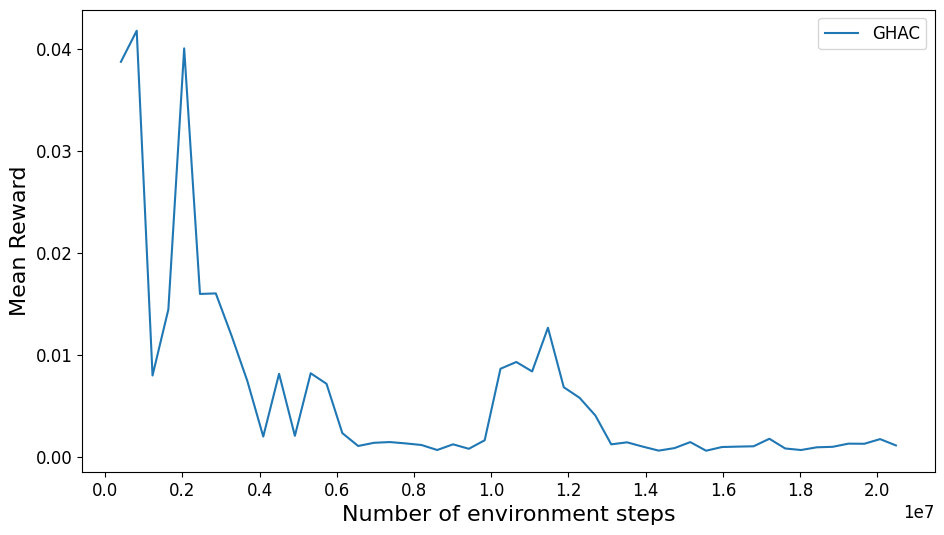

In [35]:
fix, ax = plt.subplots(figsize=(11, 6))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(12)
ax.set_xticks([2 * prefix * 10**6 for prefix in range(0, 11)])

ax.plot(step_values, ghac_losses, label=r"GHAC")

plt.xlabel('Number of environment steps', fontsize=16)
plt.ylabel('Mean Reward', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.savefig("mean_reward_plot")